# ***Importing Modules***

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

In [ ]:
!mkdir -p /content/temp_unzip
!unzip /content/flickr8k.zip -d /content/temp_unzip

!mkdir -p /content/drive/MyDrive/Image_Caption_Generator

!mv /content/temp_unzip/* /content/drive/MyDrive/Image_Caption_Generator/

!rm -rf /content/temp_unzip

## **Setting up the Base Directory & Working Directory**



1.   Base Directory: "A base directory is the starting folder or top-level path that serves as the reference point for locating other files and subdirectories."

2.   Working Directory: "A working directory is the specific folder where you are currently located and where the system looks for files or executes commands by default."



In [ ]:
# Path where the specific dataset images are located
BASE_DIR = '/content/drive/MyDrive/Image_Caption_Generator/flickr8k'

# Path where you want to save your pickle files and models
WORKING_DIR = '/content/drive/MyDrive/Image_Caption_Generator'

## Extract the features from the Images using CNN

pre-trained CNN **VGG16** to convert each image → 4096-dimensional feature vector.

VGG16: VGG16 is a classical 16-layer convolutional neural network (CNN) developed by the Visual Geometry Group at Oxford, known for its simple yet powerful architecture that uses small (3x3) convolution filters throughout. It excels at image classification and is widely used today as a robust feature extractor for transfer learning tasks.

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

### Saving the features in a pickle file

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'new-method-features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'new-method-features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Mapping & cleaning the captions

Cleaning simplifies the text by removing noise like punctuation and casing, allowing the model to focus on learning meaningful word representations. Mapping organizes the dataset by linking each image ID to its corresponding captions, ensuring the model can correctly associate visual features with text during training.

Loading Captions

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

Mapping captions to their corresponding image_id

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

Cleaning the mapped captions

In [ ]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps

            # convert to lowercase
            caption = caption.lower()

            # delete digits, special chars, etc. (Keep only letters and spaces)
            # We use re.sub instead of replace
            caption = re.sub(r'[^a-zA-Z\s]', '', caption)

            # delete additional spaces (collapse multiple spaces into one)
            caption = re.sub(r'\s+', ' ', caption)

            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

Store preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Preprocessing the Text data

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8768

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

Split the data into Training & Testing set

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

**Define batch & including the padding sequence**

Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop indefinitely
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # Split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]

                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Store
                    if key in features:
                        # We use .reshape(4096) to ensure it's a vector, not a scalar.
                        # This works whether your features are (1, 4096) or (4096,)
                        feature = np.array(features[key]).reshape(4096)

                        X1.append(feature)
                        X2.append(in_seq)
                        y.append(out_seq)

            # Yield batch data
            if n == batch_size:
                # Yield tuple ((image_features, text_sequences), target_word)
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation
* shape=(4096,) - output length of the features
from the VGG model

* Dense - single dimension linear layer array

* Dropout() - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

* model.compile() - compilation of the model

* loss=’sparse_categorical_crossentropy’ - loss function for category outputs

* optimizer=’adam’ - automatically adjust the learning rate for the model over the no. of epochs

* Model plot shows the concatenation of the inputs and outputs into a single layer

* Feature extraction of image was already done using VGG, no CNN model was needed in this step

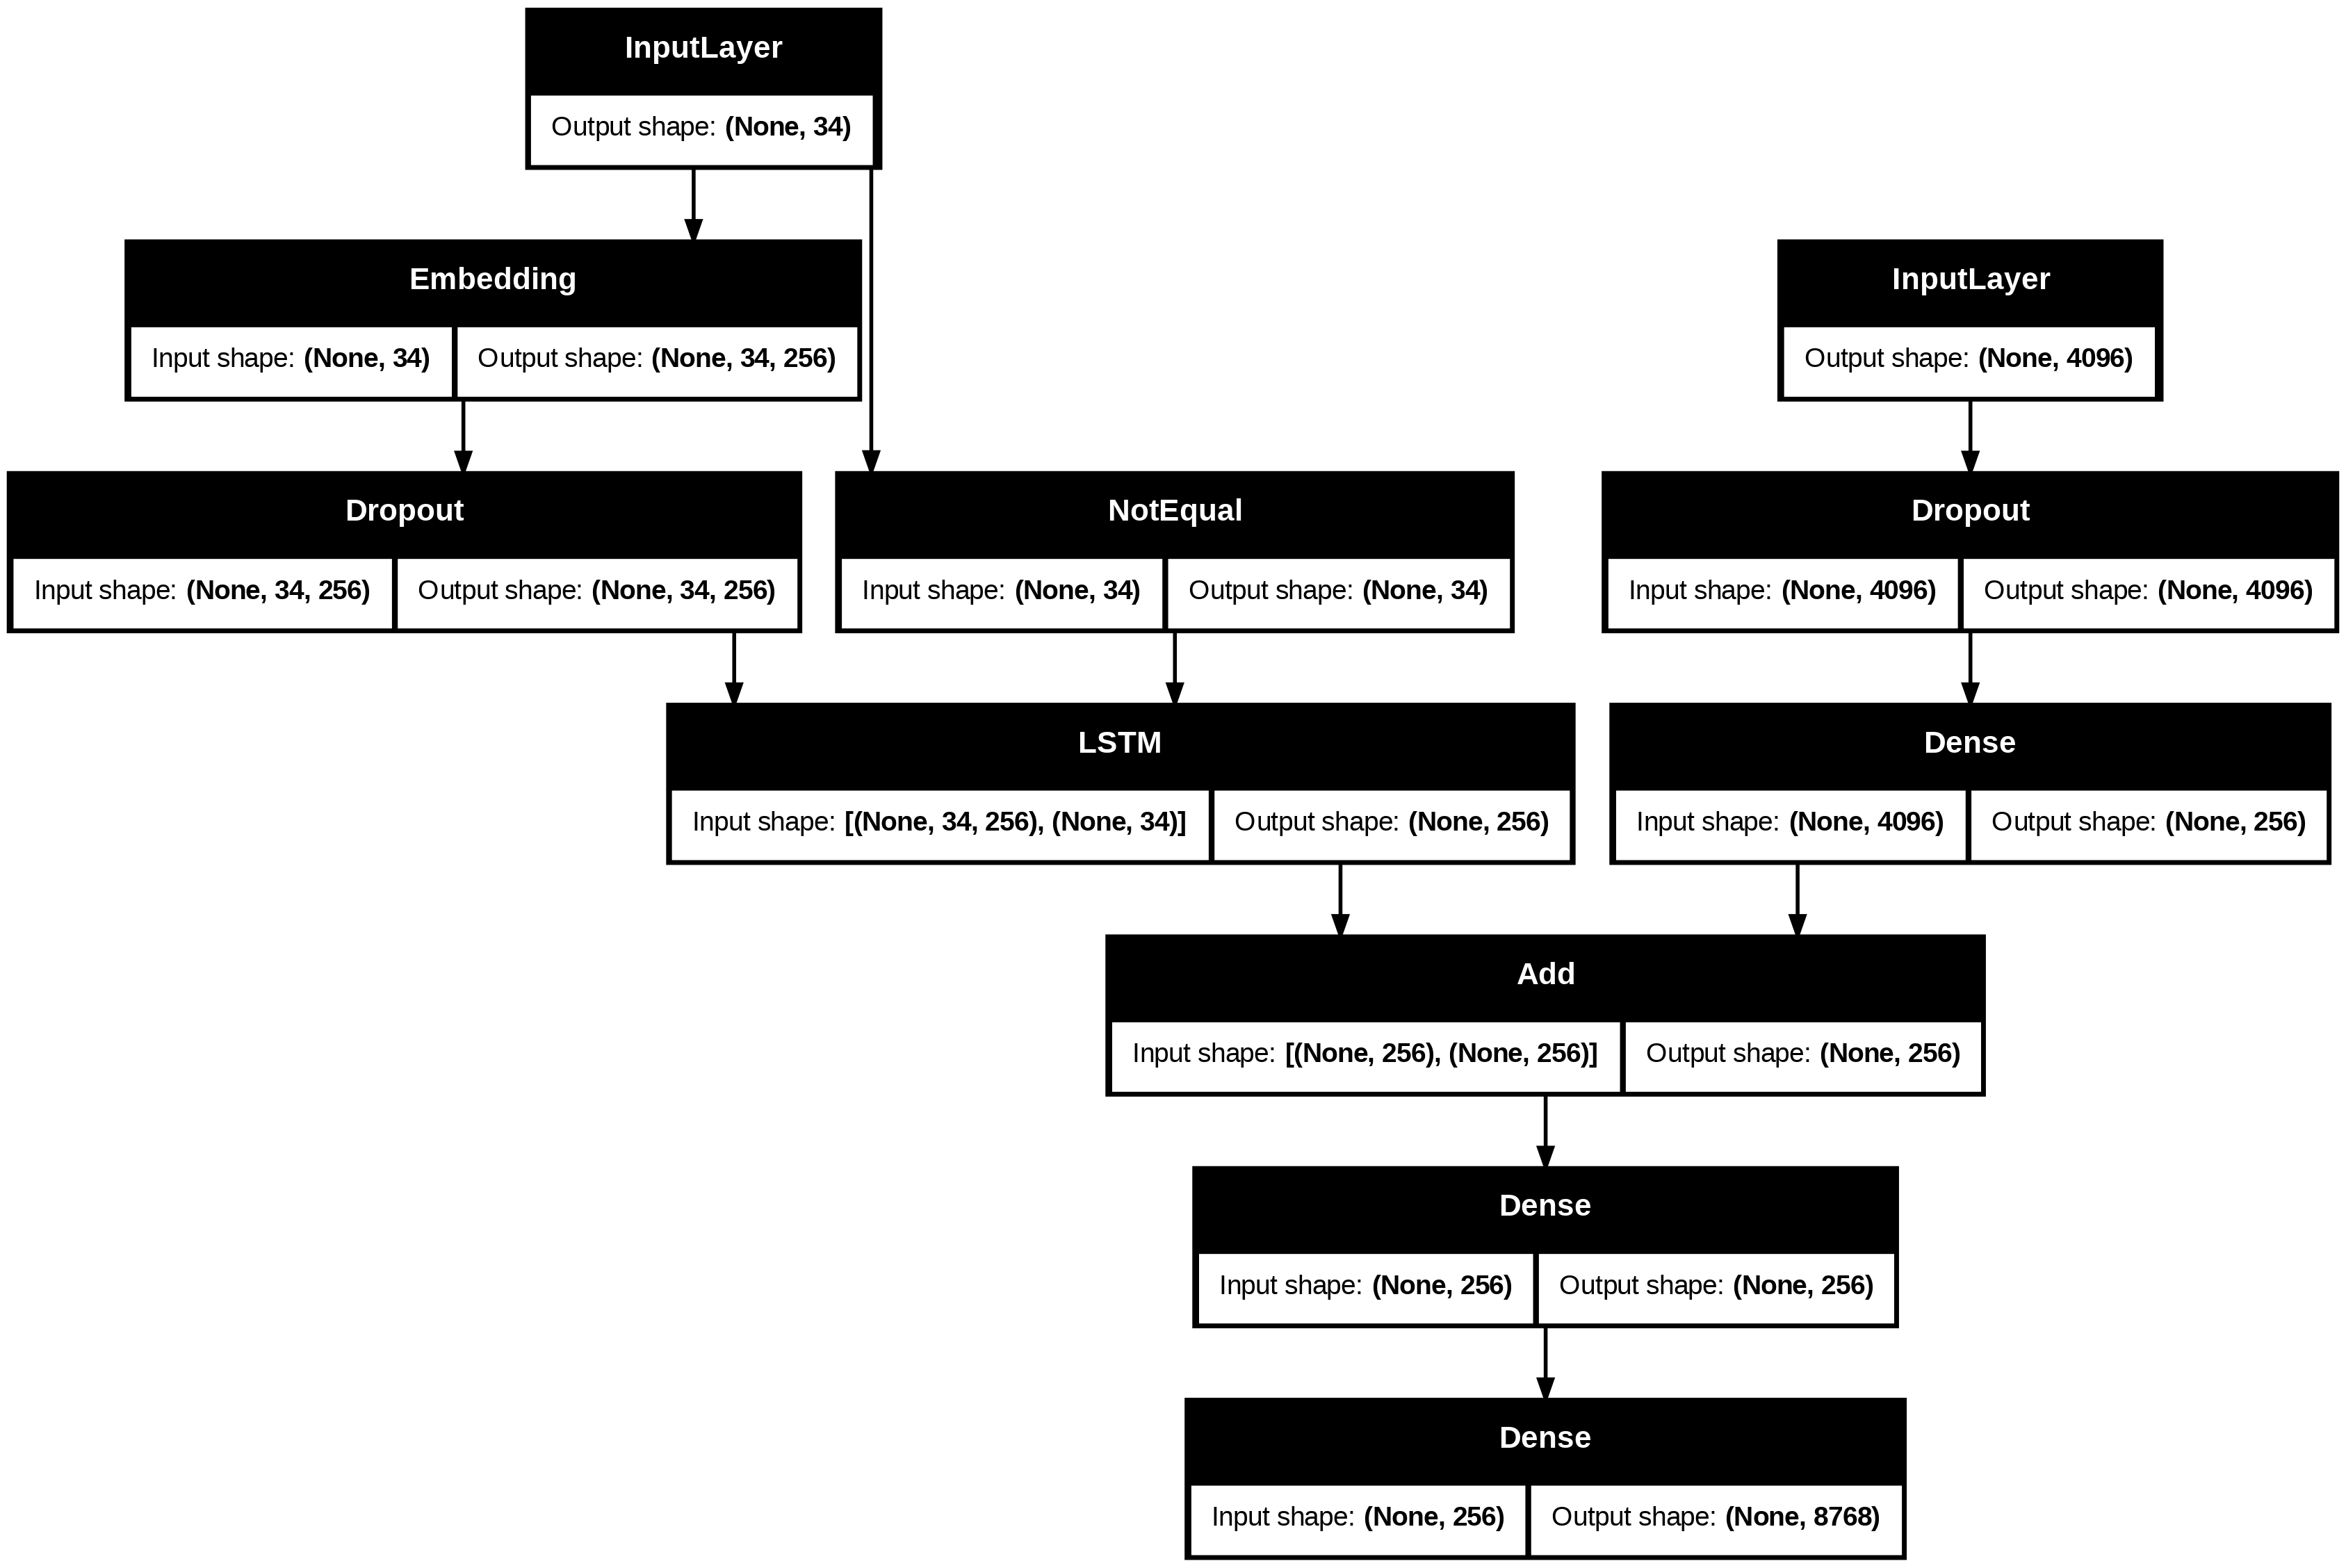

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

### Training the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# This saves the model to 'best_model.h5' whenever 'loss' decreases.
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Stops training if loss doesn't improve for 3 epochs (saves time!)
early_stop = EarlyStopping(monitor='loss', patience=3)

generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

In [ ]:
# Keras handles the looping and saving for you.
model.fit(
    generator,
    epochs=20,
    steps_per_epoch=steps,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 260ms/step - loss: 5.7832
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 251ms/step - loss: 4.0612
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 253ms/step - loss: 3.5851
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 251ms/step - loss: 3.2977
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 249ms/step - loss: 3.0878
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 252ms/step - loss: 2.9302
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 259ms/step - loss: 2.8119
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 249ms/step - loss: 2.7167
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - loss: 2.6420
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - loss: 2.5732
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 254ms/step - loss: 2.5102
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 253ms/step - loss: 2.4536
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 254ms/step - loss: 2.4033
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 259ms/step - loss: 2.3607
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - loss: 2.3219
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - loss: 2.2797
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - loss: 2.24

## Generate Captions for the image

Convert predicted index to word

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    image = image.reshape(1, 4096)

    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # predict next word
        yhat = model.predict([image, sequence], verbose=0)

        # get index with high probability
        yhat = np.argmax(yhat)

        # map integer to word
        word = idx_to_word(yhat, tokenizer)

        # stop if we cannot map the word
        if word is None:
            break

        # append as input for generating the next word
        in_text += ' ' + word

        # stop if we predict the end of the sequence
        if word == 'endseq':
            break

    return in_text

Compute the BLEU scores for the Test Data

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.539695
BLEU-2: 0.315355


## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq cart containig two men being pulled by horses in the rain endseq
startseq horse driven carriage running through rainstorm endseq
startseq black and white horses carry cart with people through the rain endseq
startseq people enjoy horse draw open carriage in the rain endseq
startseq the horses pull the carriage holding people and dog through the rain endseq
--------------------Predicted--------------------
startseq man in black coat is leading large draft horse endseq


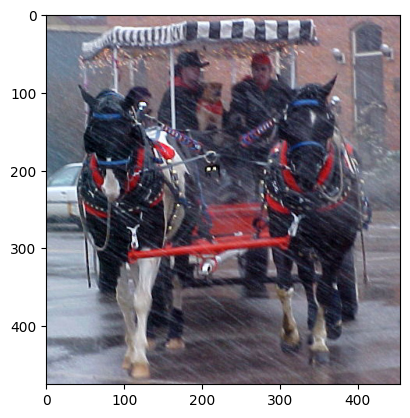

In [ ]:
generate_caption("97731718_eb7ba71fd3.jpg")

---------------------Actual---------------------
startseq man in pink shirt climbs rock face endseq
startseq man is rock climbing high in the air endseq
startseq person in red shirt climbing up rock face covered in assist handles endseq
startseq rock climber in red shirt endseq
startseq rock climber practices on rock climbing wall endseq
--------------------Predicted--------------------
startseq man wearing red shirt is climbing rock cliff endseq


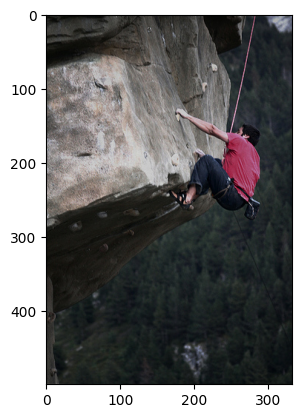

In [ ]:
generate_caption("997722733_0cb5439472.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two skiers are displaying pictures on snowy trail endseq


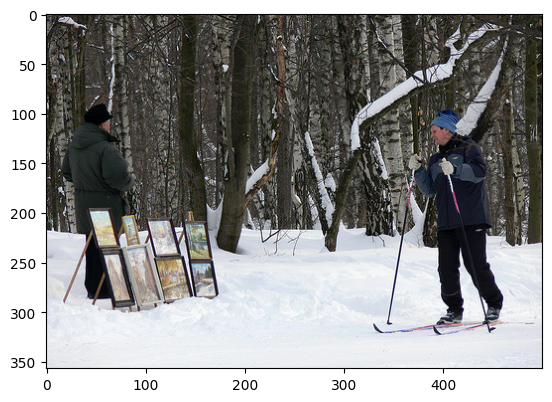

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq man does wheelie on his bicycle on the sidewalk endseq
startseq man is doing wheelie on mountain bike endseq
startseq man on bicycle is on only the back wheel endseq
startseq asian man in orange hat is popping wheelie on his bike endseq
startseq man on bicycle riding on only one wheel endseq
--------------------Predicted--------------------
startseq man in black shirt and white shorts is riding bicycle on the street endseq


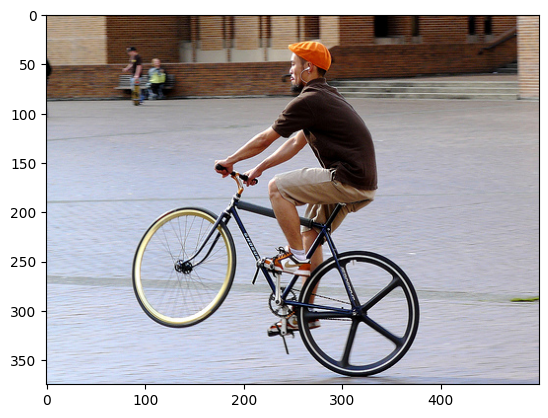

In [ ]:
generate_caption("990890291_afc72be141.jpg")